#*EEG-LiT*







In [1]:
#@title Install dependencies
!pip install numpy
!pip install pandas
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
!pip install scikit-learn
!pip install transformers
!pip install tqdm
!pip install matplotlib

Looking in indexes: https://download.pytorch.org/whl/cu117


In [2]:
#@title Install libraries

from enum import Enum
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import transformers
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.cluster import KMeans
from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTModel
from tqdm import tqdm
from matplotlib import pyplot as plt
from math import floor, sqrt
import matplotlib.pyplot as pyplot


##How to Run
Select dataset from dropdown below and go to Runtime>Run all

Don't run with less than 50% data. Training step won't work.

In [3]:
#@title Select Parameters

class RunType(Enum):
    NORMAL = 1
    CLUSTER = 2
    CLASSIFIER = 3

class Environment(Enum):
  COLAB = 1
  AZURE = 2


run_type  = RunType.CLUSTER #@param [ 'RunType.NORMAL', 'RunType.CLUSTER' , 'RunType.CLASSIFIER'] {type: "raw"}

dataset_name = 'Position_task_with_dots_synchronised_min'  # @param [ 'Position_task_with_dots_synchronised_min','Position_task_with_dots_synchronised_max',  'Position_task_with_dots_synchronised_min_hilbert', 'LR_task_with_antisaccade_synchronised_min', 'test' ] {type:"string"}


percent_of_data = 1.00 # @param {type:"slider", min:0.0, max:1.0, step:0.02}

#default =0

use_augmentation = False  # @param {type:"boolean"}

# @markdown ---
#default 15
n_epoch = 15 # @param [15,30,60]{type:"raw"}
#default .0001
learning_rate = 0.0001 # @param [1e-2, 1e-3, 1e-4, 1e-5] {type:"raw"}
#default = 64
batch_size = 64 # @param [8,16,32,64,96, 128] {type:"raw"}
#default = 6
step_size = 6 # @param [6,8,10,20] {type:"raw"}
#default = .1
dropout = 0.1 # @param [0.0, 0.1, 0.2, 0.3, 0.4, 0.5] {type:"raw"}

l2_regularization = 0  # @param [0, 0.1, 0.01, 0.001] {type:"raw"}


# @markdown ---

environment = Environment.COLAB #@param ['Environment.COLAB', 'Environment.AZURE'] {type:"raw"}


save_model_as = 'EEG-LiT-best.pt'# @param {type:"string"}

# @markdown ---
kernel1, kernel2 = [(1,36), (8,1)]
data_shape = [500, 129]
plot_threshold= 55.4

conv1_bias = False

num_clusters = 25




## Download Dataset
Store dataset in Google Drive for persistent storage

In [4]:
# download data
if environment == Environment.COLAB:
  !pip install torch
  from google.colab import drive
  drive.mount('/content/drive')


file_dir = '/content/drive/MyDrive/EEGViT_DATA/'

if not os.path.exists(f'{file_dir}{dataset_name}.npz'):
  !mkdir {file_dir}

  !wget -P {file_dir} https://files.osf.io/v1/resources/ktv7m/providers/dropbox/prepared/{dataset_name}.npz




Mounted at /content/drive


In [5]:
# Set seed for reproducibility
SEED = 2
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

#Define Model Code Base

Reference of the following cell: [EEGViT](https://github.com/ruiqiRichard/EEGViT)

In [6]:
class EEGEyeNetDataset(Dataset):
    def __init__(self, data_file, transpose = True, transform=None):

        print('loading data...')
        with np.load(data_file) as f: # Load the data array
            num_elements = int(len(f['EEG']) * percent_of_data)
            self.trainX = f['EEG'][:num_elements]
            self.trainY = pd.DataFrame(f['labels'][:num_elements])
            self.trainY = self.trainY.drop(0, axis=1)

        print(self.trainY)
        if transpose:
            self.trainX = np.transpose(self.trainX, (0,2,1))[:,np.newaxis,:,:]

        self.transform=transform

    def __getitem__(self, index):
        # Read a single sample of data from the data array
        X = torch.from_numpy(self.trainX[index]).float()
        y = torch.from_numpy(self.trainY.loc[index][0:2].values).float()
        # Return the tensor data
        if self.transform:
          X = self.transform(X)

        return (X,y,index)

    def __len__(self):
        # Compute the number of samples in the data array
        return len(self.trainX)

class EEGViT_classifier(nn.Module):
    def __init__(self, dropout = 0.1, conv1_bias = False, channels1=64, channels2=768,m2=768, model_name="google/vit-base-patch16-224", kernel1=(1,35), kernel2=(8,1)):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=channels1,
            kernel_size=kernel1,
            stride=kernel1,
            padding=(0,0),
            bias=conv1_bias
        )

        self.batchnorm1 = nn.BatchNorm2d(channels1, eps=1e-12)
        # self.batchnorm1 = nn.BatchNorm2d(256, False)
        img_size = (round(500/kernel1[1]), round(129/kernel2[0]))

        config = transformers.ViTConfig.from_pretrained(model_name)
        config.update({'num_channels': channels1})
        config.update({'image_size': (129, img_size[0] )})
        config.update({'patch_size': (kernel2) })

        model = transformers.ViTForImageClassification.from_pretrained(model_name, config=config, ignore_mismatched_sizes=True)
        model.vit.embeddings.patch_embeddings.projection = torch.nn.Conv2d(channels1, channels2, kernel_size=kernel2, stride=kernel2, padding=(0,0), groups=channels1)
        model.classifier=torch.nn.Sequential(torch.nn.Linear(m2,1000,bias=True),
                                     torch.nn.Dropout(p=dropout),
                                     torch.nn.Linear(1000,num_clusters,bias=True))

        self.ViT = model

    def forward(self,x):
        x = self.conv1(x)
        # print("After conv1:", x.shape)
        x = self.batchnorm1(x)
        # print("After batchnorm1:", x.shape)
        x = self.ViT.forward(x).logits
        # print("After ViT:", x.shape)
        return x



class EEGViT_pretrained(nn.Module):
    def __init__(self):
        super().__init__()
        # First Convolution Layer
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=256,
            kernel_size=(1, 36),
            stride=(1, 36),
            padding=(0, 2),
            bias=False
        )

        # Depthwise Separable Convolution Layer
        self.depthwise_conv = nn.Conv2d(
            in_channels=256,
            out_channels=256,
            kernel_size=(3, 3),
            padding=1,
            groups=256
        )
        self.pointwise_conv = nn.Conv2d(
            in_channels=256,
            out_channels=512,
            kernel_size=1
        )

        # Batch Normalization
        self.batchnorm1 = nn.BatchNorm2d(256, False)
        self.batchnorm2 = nn.BatchNorm2d(512, False)

        # Vision Transformer Configuration
        model_name = "google/vit-base-patch16-224"
        config = transformers.ViTConfig.from_pretrained(model_name)
        config.update({'num_channels': 512})
        config.update({'image_size': (129,14)})
        config.update({'patch_size': (8,1)})

        model = transformers.ViTForImageClassification.from_pretrained(
            model_name,
            config=config,
            ignore_mismatched_sizes=True
        )
        model.vit.embeddings.patch_embeddings.projection = nn.Conv2d(
            512,
            768,
            kernel_size=(8, 1),
            stride=(8, 1),
            padding=(0,0),
            groups=256
        )
        model.classifier = nn.Sequential(
            nn.Linear(768, 1000, bias=True),
            nn.Dropout(p=0.1),
            nn.Linear(1000, 2, bias=True)
        )
        self.ViT = model

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.depthwise_conv(x)
        x = self.pointwise_conv(x)
        x = self.batchnorm2(x)
        x = self.ViT.forward(x).logits
        return x


## Load Base Model and Data into Memory

In [7]:
EEGEyeNet = EEGEyeNetDataset(f'{file_dir}{dataset_name}.npz')

if use_augmentation:


  # if os.path.exists(f"{file_dir}{dataset_name}-flipped.pth"):
  #   EEGEyeNet_Flipped = torch.load(f"{file_dir}{dataset_name}-flipped.pth")
  # else:
  EEGEyeNet_Flipped = EEGEyeNetDataset(f'{file_dir}{dataset_name}.npz', transform=transforms.functional.hflip)
  torch.save(EEGEyeNet_Flipped, f"{file_dir}{dataset_name}-flipped.pth", pickle_protocol=4)


loading data...
           1      2
0      408.1  315.1
1      640.7  519.1
2      404.2  118.8
3      123.9  467.1
4      711.7  460.0
...      ...    ...
21459  725.1  156.6
21460  521.4  202.8
21461  115.5  306.1
21462  732.0  310.3
21463  632.2  353.6

[21464 rows x 2 columns]


In [8]:
EEGEyeNet.trainX[0][0].shape

(129, 500)

In [9]:
EEGEyeNet.trainX.shape

(21464, 1, 129, 500)

In [10]:
EEGEyeNet.trainY

,1,2
0,408.1,315.1
1,640.7,519.1
2,404.2,118.8
3,123.9,467.1
4,711.7,460.0
...,...,...
21459,725.1,156.6
21460,521.4,202.8
21461,115.5,306.1
21462,732.0,310.3


##Visualize Data

In [11]:

if environment == Environment.COLAB:
  from google.colab import data_table
  data_table.enable_dataframe_formatter()
  from google.colab import autoviz


In [12]:
def scatter_plots(df, colname_pairs, figscale=2, alpha=.8):

  plt.figure(figsize=(12, 8))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(2*figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
    ax.grid(True)
  plt.tight_layout()
  plt.xlim(0,800)
  plt.ylim(0,600)

  return autoviz.MplChart.from_current_mpl_state()

if environment == Environment.COLAB:
  chart = scatter_plots(EEGEyeNet.trainY, *[[[1, 2]]], **{})

  chart


#Preprocess data

#Make into Clustering Problem


In [13]:
if run_type in [RunType.CLUSTER]:

  df = EEGEyeNet.trainY

  df = df[(df >= 0).all(axis=1)]

  kmeans = KMeans(n_clusters=num_clusters, random_state = SEED)
  kmeans.fit(df.iloc[:,0:2])
  centroids = kmeans.cluster_centers_

  predictions = pd.DataFrame(kmeans.predict(df.iloc[:,0:2]), index = df.index)

  centers = pd.DataFrame(centroids[predictions.iloc[:,0]], index = predictions.index)

  EEGEyeNet.trainY = centers




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


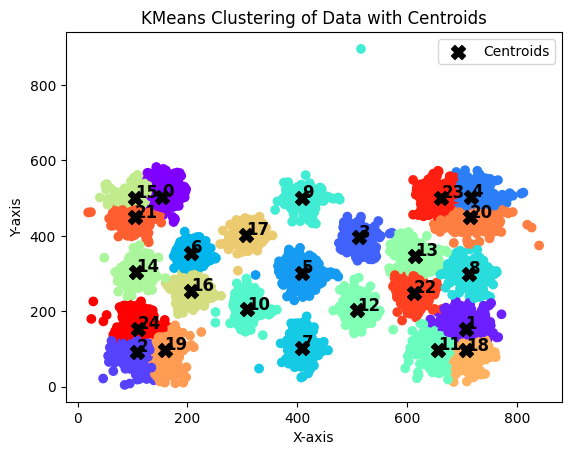

In [14]:
if run_type in [RunType.CLUSTER]:
  # Plotting the data points and centroids
  plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=predictions.iloc[:, 0], cmap='rainbow')
  plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=100, c='black', label='Centroids')

  # Annotating the centroids with predicted labels
  for i, centroid in enumerate(centroids):
      plt.annotate(str(i), (centroid[0], centroid[1]), fontsize=12, fontweight='bold')

  plt.title("KMeans Clustering of Data with Centroids")
  plt.xlabel("X-axis")
  plt.ylabel("Y-axis")
  plt.legend()
  plt.show()

<ipython-input-15-f6fd6476d8dc>:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(EEGEyeNet.trainY[0], EEGEyeNet.trainY[1], cmap='viridis', s=3)


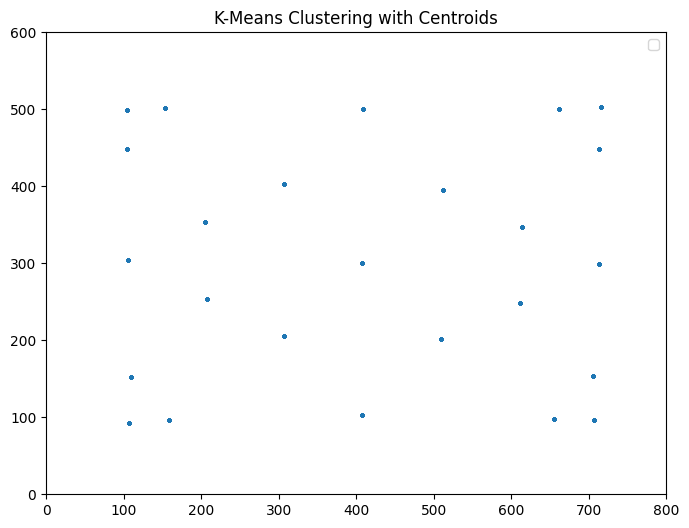

In [15]:
if run_type==RunType.CLUSTER:
  EEGEyeNet.trainY = EEGEyeNet.trainY.astype(int)

  plt.figure(figsize=(8, 6))  # Width x Height in inches

  plt.xlim(0,800)
  plt.ylim(0,600)
  plt.scatter(EEGEyeNet.trainY[0], EEGEyeNet.trainY[1], cmap='viridis', s=3)
  plt.legend()
  plt.title('K-Means Clustering with Centroids')
  plt.show()

#Make into Classification Problem

In [16]:
if run_type==RunType.CLASSIFIER:

  df = EEGEyeNet.trainY

  df = df[(df >= 0).all(axis=1)]

  kmeans = KMeans(n_clusters=num_clusters, random_state = SEED)
  kmeans.fit(df.iloc[:,0:2])
  centroids = kmeans.cluster_centers_

  predictions = pd.DataFrame(kmeans.predict(df.iloc[:,0:2]), index = df.index)

  centers = pd.DataFrame(centroids[predictions.iloc[:,0]], index = predictions.index)

  #center_points = df.apply(lambda row: predict_row(row), axis=1)

  # df_w_centroids = center_points.apply(lambda row: centroids[row[0]] )
  EEGEyeNet.trainY = predictions


In [17]:
if run_type in [RunType.CLASSIFIER]:
  plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=100, c='black', label='Centroids')

  # Annotating the centroids with predicted labels
  for i, centroid in enumerate(centroids):
      plt.annotate(str(i), (centroid[0], centroid[1]), fontsize=12, fontweight='bold')

  plt.title("KMeans Clustering of Data with Centroids")
  plt.xlabel("X-axis")
  plt.ylabel("Y-axis")
  plt.legend()
  plt.show()

#Train Model

In [18]:

match run_type:
  case RunType.CLASSIFIER:
    model = EEGViT_classifier( )
  case _:
    # model = EEGViT_pretrained(dropout, conv1_bias, channels1, channels2, m2, model_name, kernel1, kernel2)
    model=EEGViT_pretrained()



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- vit.embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 512, 8, 1]) in the model instantiated
- vit.embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 225, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_regularization)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

Reference of the following cell: [EEGViT](https://github.com/ruiqiRichard/EEGViT)

In [20]:
target_size = 4 if not run_type==RunType.CLUSTER else 8


def plot_coordinates_with_threshold(data, threshold):
    count =0
    plt.figure(figsize=(20, 14))

    for a,b,x,y, rmse in data:
        line_color = 'g' if rmse <= threshold else 'r'
        if rmse <= threshold:
            #count
            plt.plot(x, y,  'bo',markersize=4)
        else:
            plt.plot(x, y, 'rx', markersize=4 )
            count+=1

        # Plot a line between (a,b) and (x,y) with the specified color and opacity
        plt.plot([a, x], [b, y], line_color + '-', alpha=0.02)
        plt.plot(a, b,  'bo',markersize=target_size, alpha=0.05)


    plt.xlim(0,800)
    plt.ylim(0,600)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("Coordinates Categorized by RMSE")
    print(count)
    plt.show()

def split(data):
    # Calculate the split points

    split1 = len(data)-3481-3277
    split2 = len(data)-3481

    # Split the data into three parts
    train = data[:split1]
    val = data[split1:split2]
    test = data[split2:]

    return train, val, test

def train(model, optimizer, scheduler = None):
    '''
      model: model to train
      optimizer: optimizer to update weights
      scheduler: scheduling learning rate, used when finetuning pretrained models
    '''
    torch.cuda.empty_cache()

    train_indices, val_indices, test_indices = split(EEGEyeNet.trainY.index)

    print(f'train: {len(train_indices)}, val: {len(val_indices)} test: {len(test_indices)}')

    print('create dataloader...')
    train = Subset(EEGEyeNet,indices=train_indices)
    val = Subset(EEGEyeNet,indices=val_indices)
    test = Subset(EEGEyeNet,indices=test_indices)

    if use_augmentation:
      flipped_train = Subset(EEGEyeNet_Flipped,indices=train_indices)
      augmented_train = ConcatDataset([train, flipped_train])
      train_loader = DataLoader(augmented_train, batch_size=batch_size, shuffle=True)
    else:
      train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

    val_loader = DataLoader(val, batch_size=batch_size)
    test_loader = DataLoader(test, batch_size=1)


    print("HI")

    if torch.cuda.is_available():
      gpu_id = 0  # Change this to the desired GPU ID if you have multiple GPUs
      torch.cuda.set_device(gpu_id)
      device = torch.device(f"cuda:{gpu_id}")
    else:
      device = torch.device("cpu")

    if torch.cuda.device_count() > 1:
      model = nn.DataParallel(model)  # Wrap the model with DataParallel

    model = model.to(device)

    match run_type:
      case RunType.CLASSIFIER:
        criterion = nn.CrossEntropyLoss()
      case _:
        criterion = nn.MSELoss()

    criterion = criterion.to(device)

    # Initialize lists to store losses
    train_losses = []
    val_losses = []
    test_losses = []

    print('training...')
    # Train the model


    for epoch in range(n_epoch):
      model.train()
      epoch_train_loss = 0.0

      true_labels = []
      predicted_labels = []
      output_and_rmse = []
      i=0

      # print(tqdm(enumerate(train_loader)))
      for value in train_loader:

        inputs, targets, index = value
        if run_type == RunType.CLASSIFIER:
          targets = targets.long()

        # Move the inputs and targets to the GPU (if available)
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Compute the outputs and loss for the current batch
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs.squeeze(), targets.squeeze())

        # Compute the gradients and update the parameters
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

        # Print the loss and accuracy for the current batch
        if i % 100 == 0:
            print(f"Epoch {epoch}, batch {i} train Loss: {loss.item()}")

        i+=1

      epoch_train_loss /= len(train_loader)
      train_losses.append(epoch_train_loss)

      # Evaluate the model on the validation set
      model.eval()


      if len(val_indices)>0:
        with torch.no_grad():
          val_loss = 0.0
          for inputs, targets, index in val_loader:
            # Move the inputs and targets to the GPU (if available)
            if run_type == RunType.CLASSIFIER:
              targets = targets.long()

            inputs = inputs.to(device)
            targets = targets.to(device)
            # Compute the outputs and loss for the current batch
            outputs = model(inputs)
            # print(outputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())
            val_loss += loss.item()

          val_loss /= len(val_loader)

          val_losses.append(val_loss)

          if val_loss == min(val_losses):
            print(f"Epoch {epoch}, Val Loss: {val_loss} (best so far, saving..)")
            torch.save(model.state_dict(), f'{file_dir}{save_model_as}')



          print(f"Epoch {epoch}, Val Loss: {val_loss}")
        print(f"best validation loss: {min(val_losses)}")

      if len(test_indices)>0:
        with torch.no_grad():
          val_loss = 0.0

          for inputs, targets, index in test_loader:
            # Move the inputs and targets to the GPU (if available)

            if run_type == RunType.CLASSIFIER:
              targets = targets.long()

            inputs = inputs.to(device)
            targets = targets.to(device)
            # Compute the outputs and loss for the current batch
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())
            val_loss += loss.item()

            #classifier
            if run_type == RunType.CLASSIFIER:
              _, preds = torch.max(outputs, 1)
              true_labels.extend(targets.cpu().numpy())
              predicted_labels.extend(preds.cpu().numpy())

            if  run_type in [RunType.NORMAL, RunType.CLUSTER]:
              x,y = outputs.tolist()[0]
              a,b = targets.tolist()[0]

              output_and_rmse.append([a,b,x,y, sqrt(loss.item())])


          val_loss /= len(test_loader)
          test_losses.append(val_loss)
          print(f"Epoch {epoch}, test Loss: {val_loss}")

        print(f"best test loss: {min(test_losses)}")

      if scheduler is not None:
        scheduler.step()

      pyplot.plot(train_losses, label = "Training Loss")
      pyplot.plot(val_losses, label= "Validation Loss")
      pyplot.plot(test_losses, label = "Test Loss")
      pyplot.legend()
      pyplot.show()

      # if  run_type in [RunType.NORMAL, RunType.CLUSTER]:
      #   plot_coordinates_with_threshold(output_and_rmse, plot_threshold)

      # #classifier
      # if run_type == RunType.CLASSIFIER:
      #   cm = confusion_matrix(true_labels, predicted_labels, labels=range(num_clusters))
      #   disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=range(num_clusters))
      #   fig, ax = plt.subplots(figsize=(10 ,10))
      #   disp.plot(ax=ax)
      #   plt.show()

      #   report = classification_report(true_labels, predicted_labels, labels=range(num_clusters))
      #   print(report)

## Begin Training

train: 14696, val: 3277 test: 3481
create dataloader...
HI
training...
Epoch 0, batch 0 train Loss: 169642.984375
Epoch 0, batch 100 train Loss: 76440.765625
Epoch 0, batch 200 train Loss: 35516.7890625
Epoch 0, Val Loss: 28508.467059795672 (best so far, saving..)
Epoch 0, Val Loss: 28508.467059795672
best validation loss: 28508.467059795672
Epoch 0, test Loss: 28296.96260021545
best test loss: 28296.96260021545


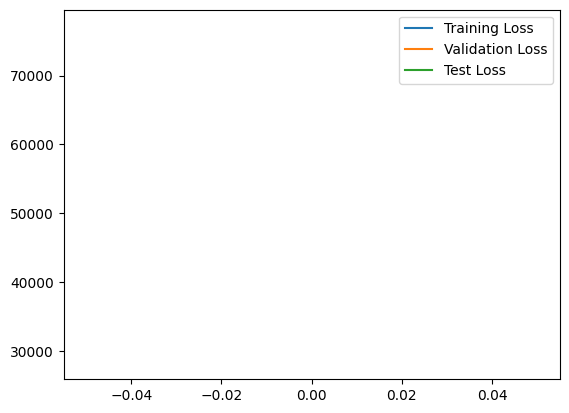

Epoch 1, batch 0 train Loss: 29458.7890625
Epoch 1, batch 100 train Loss: 27972.94140625
Epoch 1, batch 200 train Loss: 20312.7578125
Epoch 1, Val Loss: 23638.49981219952 (best so far, saving..)
Epoch 1, Val Loss: 23638.49981219952
best validation loss: 23638.49981219952
Epoch 1, test Loss: 22355.626219747533
best test loss: 22355.626219747533


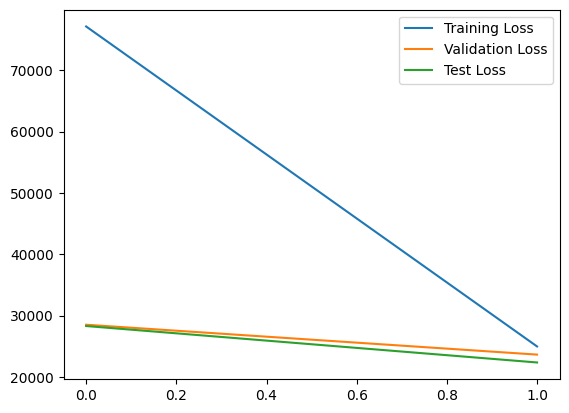

Epoch 2, batch 0 train Loss: 33474.84765625
Epoch 2, batch 100 train Loss: 23141.720703125
Epoch 2, batch 200 train Loss: 17380.2890625
Epoch 2, Val Loss: 18752.822735126203 (best so far, saving..)
Epoch 2, Val Loss: 18752.822735126203
best validation loss: 18752.822735126203
Epoch 2, test Loss: 16631.794451176862
best test loss: 16631.794451176862


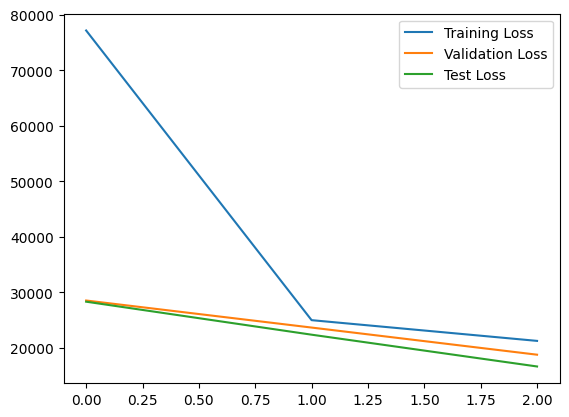

Epoch 3, batch 0 train Loss: 23695.125
Epoch 3, batch 100 train Loss: 17832.87109375
Epoch 3, batch 200 train Loss: 12096.001953125
Epoch 3, Val Loss: 15636.356219951924 (best so far, saving..)
Epoch 3, Val Loss: 15636.356219951924
best validation loss: 15636.356219951924
Epoch 3, test Loss: 13033.792222278278
best test loss: 13033.792222278278


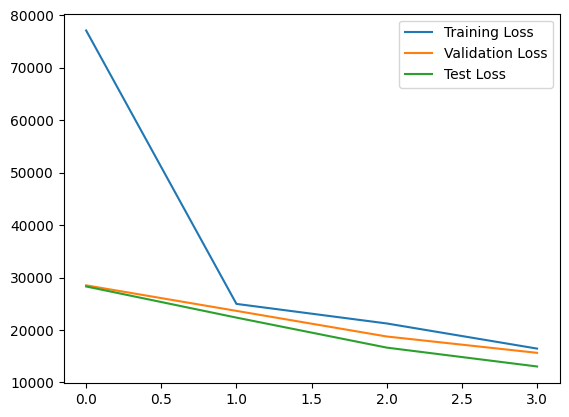

Epoch 4, batch 0 train Loss: 15709.86328125
Epoch 4, batch 100 train Loss: 19208.16796875
Epoch 4, batch 200 train Loss: 14514.4560546875
Epoch 4, Val Loss: 15147.011399489184 (best so far, saving..)
Epoch 4, Val Loss: 15147.011399489184
best validation loss: 15147.011399489184
Epoch 4, test Loss: 12137.354758831661
best test loss: 12137.354758831661


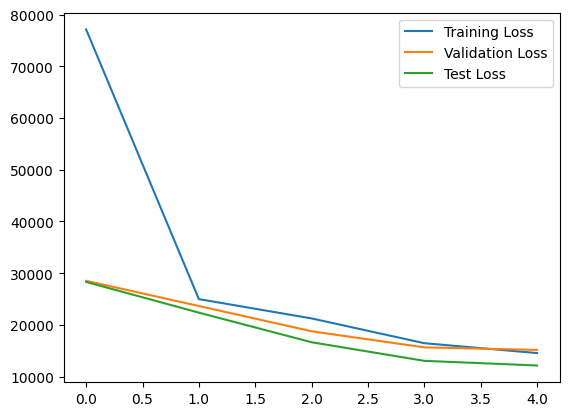

Epoch 5, batch 0 train Loss: 13572.3701171875
Epoch 5, batch 100 train Loss: 16970.2890625
Epoch 5, batch 200 train Loss: 11305.44921875
Epoch 5, Val Loss: 14306.073298527645 (best so far, saving..)
Epoch 5, Val Loss: 14306.073298527645
best validation loss: 14306.073298527645
Epoch 5, test Loss: 11172.829114545473
best test loss: 11172.829114545473


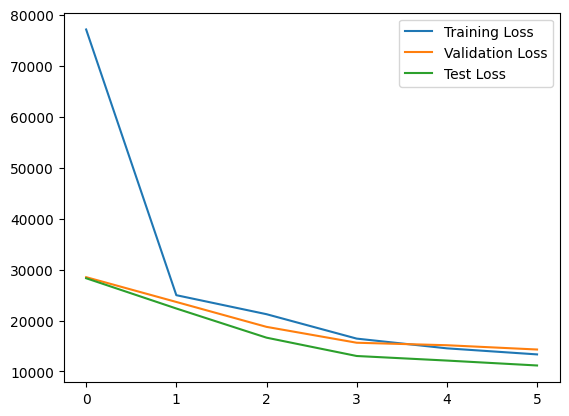

Epoch 6, batch 0 train Loss: 11650.68359375
Epoch 6, batch 100 train Loss: 11043.05859375
Epoch 6, batch 200 train Loss: 10441.255859375
Epoch 6, Val Loss: 13951.268338716947 (best so far, saving..)
Epoch 6, Val Loss: 13951.268338716947
best validation loss: 13951.268338716947
Epoch 6, test Loss: 10748.127654355752
best test loss: 10748.127654355752


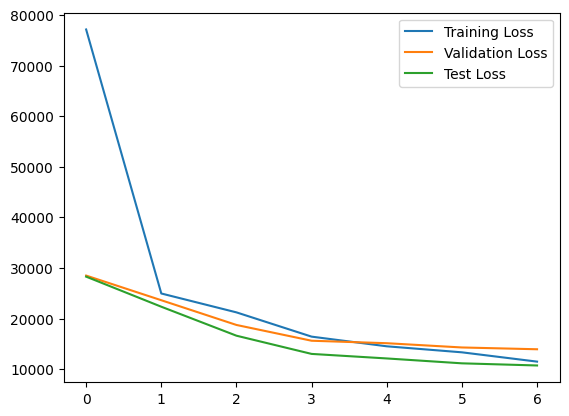

Epoch 7, batch 0 train Loss: 14821.1611328125
Epoch 7, batch 100 train Loss: 11975.294921875
Epoch 7, batch 200 train Loss: 9085.6767578125
Epoch 7, Val Loss: 13995.993192232572
best validation loss: 13951.268338716947
Epoch 7, test Loss: 10736.53609420732
best test loss: 10736.53609420732


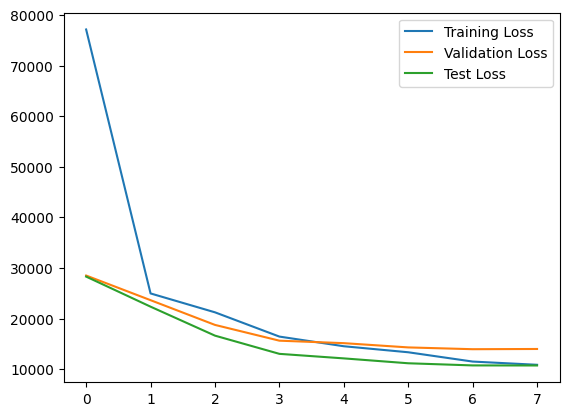

Epoch 8, batch 0 train Loss: 5135.44140625
Epoch 8, batch 100 train Loss: 11415.23046875
Epoch 8, batch 200 train Loss: 5770.486328125
Epoch 8, Val Loss: 14229.180448091947
best validation loss: 13951.268338716947
Epoch 8, test Loss: 10901.655435339811
best test loss: 10736.53609420732


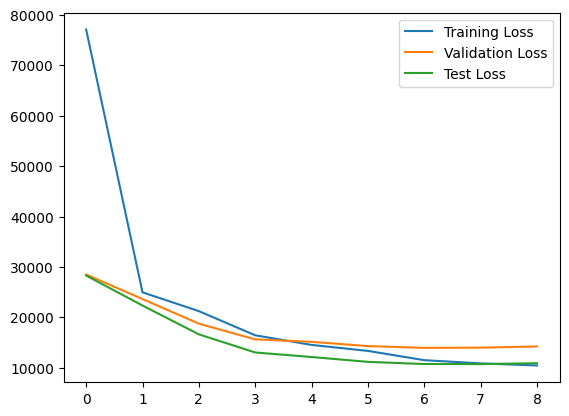

Epoch 9, batch 0 train Loss: 16209.8447265625
Epoch 9, batch 100 train Loss: 7770.4326171875
Epoch 9, batch 200 train Loss: 11351.5498046875
Epoch 9, Val Loss: 14340.841036283053
best validation loss: 13951.268338716947
Epoch 9, test Loss: 10873.015116003302
best test loss: 10736.53609420732


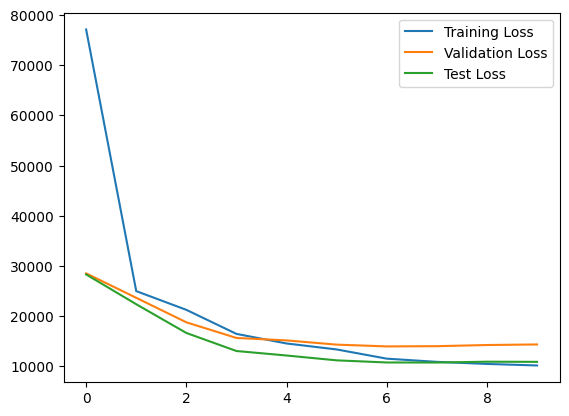

Epoch 10, batch 0 train Loss: 11440.3212890625
Epoch 10, batch 100 train Loss: 11324.765625
Epoch 10, batch 200 train Loss: 12979.162109375
Epoch 10, Val Loss: 14496.076819786658
best validation loss: 13951.268338716947
Epoch 10, test Loss: 11029.731643268686
best test loss: 10736.53609420732


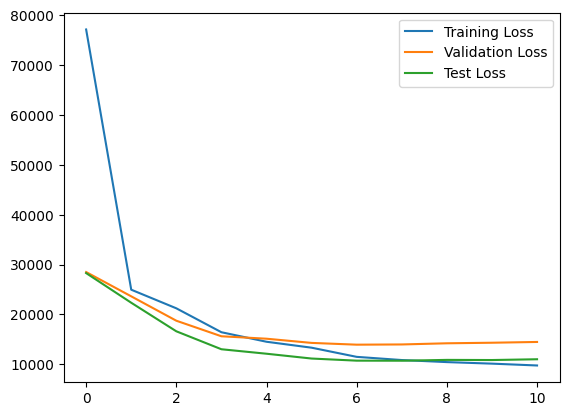

Epoch 11, batch 0 train Loss: 18224.01171875
Epoch 11, batch 100 train Loss: 9867.498046875
Epoch 11, batch 200 train Loss: 10293.2529296875
Epoch 11, Val Loss: 14487.262807992789
best validation loss: 13951.268338716947
Epoch 11, test Loss: 10994.57569929401
best test loss: 10736.53609420732


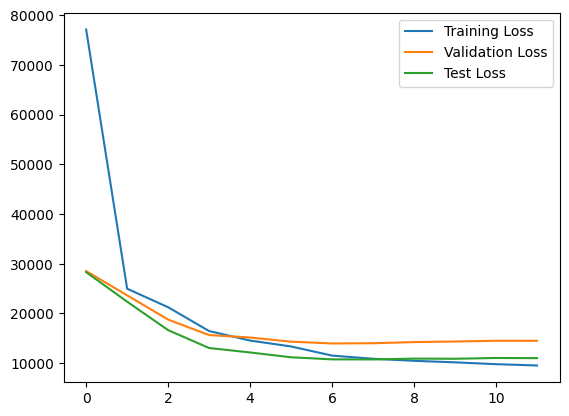

Epoch 12, batch 0 train Loss: 9033.578125
Epoch 12, batch 100 train Loss: 9434.6904296875
Epoch 12, batch 200 train Loss: 5678.0556640625
Epoch 12, Val Loss: 14734.631272536059
best validation loss: 13951.268338716947
Epoch 12, test Loss: 11134.724061909916
best test loss: 10736.53609420732


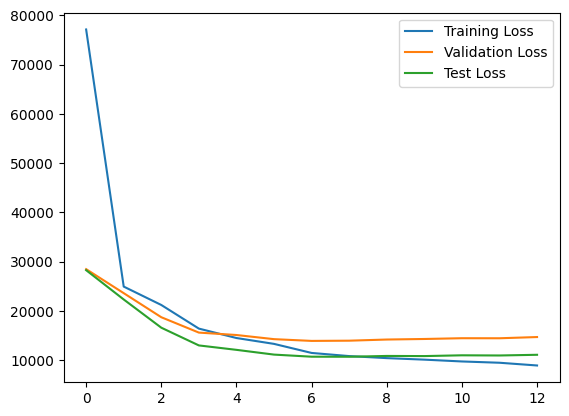

Epoch 13, batch 0 train Loss: 10991.095703125
Epoch 13, batch 100 train Loss: 6123.63427734375
Epoch 13, batch 200 train Loss: 9043.81640625
Epoch 13, Val Loss: 14552.103740985576
best validation loss: 13951.268338716947
Epoch 13, test Loss: 11003.707192418151
best test loss: 10736.53609420732


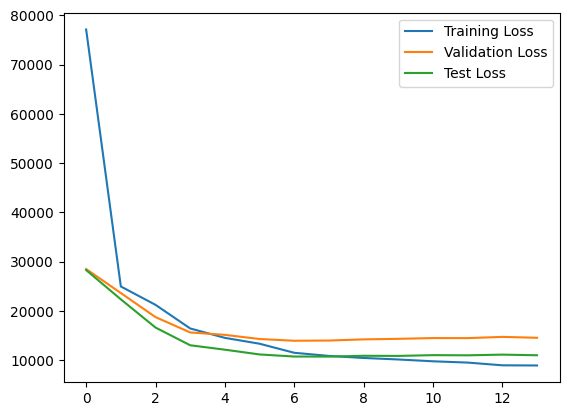

Epoch 14, batch 0 train Loss: 7944.38525390625
Epoch 14, batch 100 train Loss: 9654.3349609375
Epoch 14, batch 200 train Loss: 8374.73828125
Epoch 14, Val Loss: 14619.248215895434
best validation loss: 13951.268338716947
Epoch 14, test Loss: 11062.911700110262
best test loss: 10736.53609420732


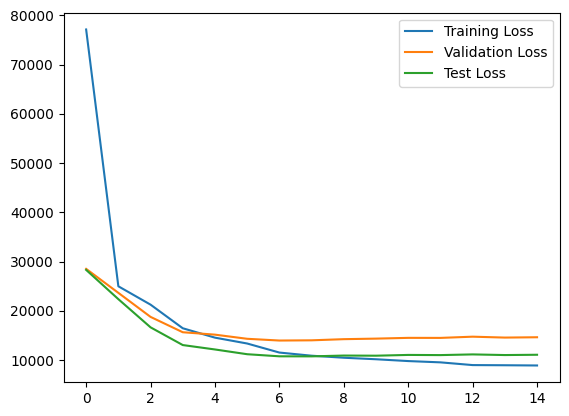

In [21]:

train(model,optimizer=optimizer, scheduler=scheduler)

## Stop Runtime
stop runtime so it doesnt charge for more time

In [ ]:
#stop runtime
from google.colab import runtime
runtime.unassign()